# MLP Regression to predict $\log{S}$

This notebook performs the task of predicting $\log{S}$  values with a basic MLP regression model, and evaluating the regression model. 

## Step 1: Setting up and importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.5.1
Device available: GPU


## Step 2: Loading and visualizing the dataset

In [ ]:
def load_esol_dataset():
    df = pd.read_csv("ESolv-Rdkit-Features.csv")                                       # Read CSV from the URL
    print(f"Loaded ESOL with {len(df)} compounds")
    print(f"Columns: {df.columns.tolist()}")                                        # All columns in the dataset 
    def_features = [
        'MolWt','TPSA', 'HBD', 'HBA',
        'RotatableBonds', 'FractionCSP3', 'AromaticRings',
        'MolRefractivity', 'NumHeteroatoms',
        'NumHeavyAtoms',
    ]
    names = df['Compound ID'].astype(str).values        
    target = 'measured log solubility in mols per litre'                          
    X = df[def_features].values.astype(np.float32)
    y = df[target].values.astype(np.float32).reshape(-1, 1)

    return X, y, names

X, y, names = load_esol_dataset()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Loaded ESOL with 1128 compounds
Columns: ['Compound ID', 'smiles', 'MolWt', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotatableBonds', 'FractionCSP3', 'Number of Rings', 'AromaticRings', 'MolRefractivity', 'NumHeteroatoms', 'NumHeavyAtoms', 'Minimum Degree', 'measured log solubility in mols per litre']
Feature matrix shape: (1128, 10)
Target vector shape: (1128, 1)


Text(0.5, 1.0, 'Distribution of Solubility Values')

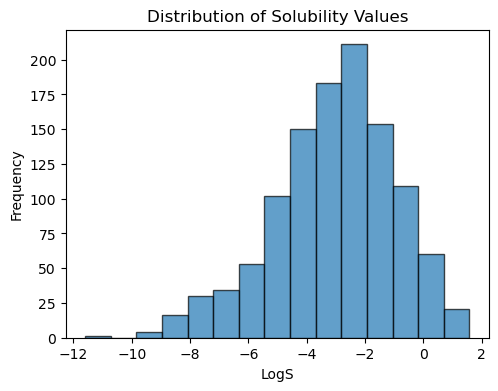

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

## Step 3: Splitting the dataset into train and test sets and normalizing it

In [ ]:
X_train, X_temp, y_train, y_temp, names_train, names_temp = train_test_split(
    X, y, names, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test, names_val, names_test = train_test_split(
    X_temp, y_temp, names_temp, test_size=0.5, random_state=42
)

dist_scaler = StandardScaler()
X_train = dist_scaler.fit_transform(X_train)
X_val = dist_scaler.transform(X_val)
X_test = dist_scaler.transform(X_test)

## Step 4: Creating a PyTorch dataloader and setting the hyperparameters

`MoleculeDataset` class converts the feature matrix into numpy arrays and the PyTorch dataloaders prepare it for input to deep learning models.

In [ ]:
class MoleculeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = MoleculeDataset(X_train, y_train)
val_ds = MoleculeDataset(X_val, y_val)
test_ds = MoleculeDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

Setting hyperparameters

In [ ]:
NUM_EPOCHS = 100
PATIENCE = 10
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

## Step 5: Defining the model, loss criterion and optimizer

In [ ]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(32, 1)
)

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANNModel(input_dim=X.shape[1]).to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

## Step 6: Training the model and plotting the loss curves

In [ ]:
train_losses = []
val_losses   = []
val_maes     = []
val_r2s      = []

wait = 0
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    # --- training step ---
    model.train()
    epoch_train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
    train_loss = np.mean(epoch_train_losses)
    train_losses.append(train_loss)

    # --- validation step ---
    model.eval()
    epoch_val_losses = []
    val_preds  = []
    val_labels = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            epoch_val_losses.append(criterion(out, yb).item())
            val_preds.extend(out.cpu().numpy().flatten())
            val_labels.extend(yb.cpu().numpy().flatten())

    val_loss = np.mean(epoch_val_losses)
    val_losses.append(val_loss)
    val_r2  = r2_score(val_labels,  val_preds)
    val_r2s.append(val_r2)

    print(f"Epoch {epoch:03d} | "
          f"Train MSE={train_loss:.4f} | "
          f"Test  MSE={val_loss:.4f}   | "
          f"Test   R²={val_r2:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 001 | Train MSE=9.5386 | Test  MSE=6.3597   | Test   R²=-0.0611
Epoch 002 | Train MSE=3.1130 | Test  MSE=2.1817   | Test   R²=0.6482
Epoch 003 | Train MSE=1.6472 | Test  MSE=1.6477   | Test   R²=0.7150
Epoch 004 | Train MSE=1.2218 | Test  MSE=1.4417   | Test   R²=0.7421
Epoch 005 | Train MSE=1.0335 | Test  MSE=1.3531   | Test   R²=0.7604
Epoch 006 | Train MSE=1.0401 | Test  MSE=1.2507   | Test   R²=0.7709
Epoch 007 | Train MSE=0.9532 | Test  MSE=1.1223   | Test   R²=0.7945
Epoch 008 | Train MSE=0.8053 | Test  MSE=1.0943   | Test   R²=0.7997
Epoch 009 | Train MSE=0.8609 | Test  MSE=1.0644   | Test   R²=0.8061
Epoch 010 | Train MSE=0.7740 | Test  MSE=1.0272   | Test   R²=0.8130
Epoch 011 | Train MSE=0.7800 | Test  MSE=1.0032   | Test   R²=0.8153
Epoch 012 | Train MSE=0.8096 | Test  MSE=0.9757   | Test   R²=0.8210
Epoch 013 | Train MSE=0.8009 | Test  MSE=1.0702   | Test   R²=0.8032
Epoch 014 | Train MSE=0.7657 | Test  MSE=1.0084   | Test   R²=0.8180
Epoch 015 | Train MSE=0.8360 | Te

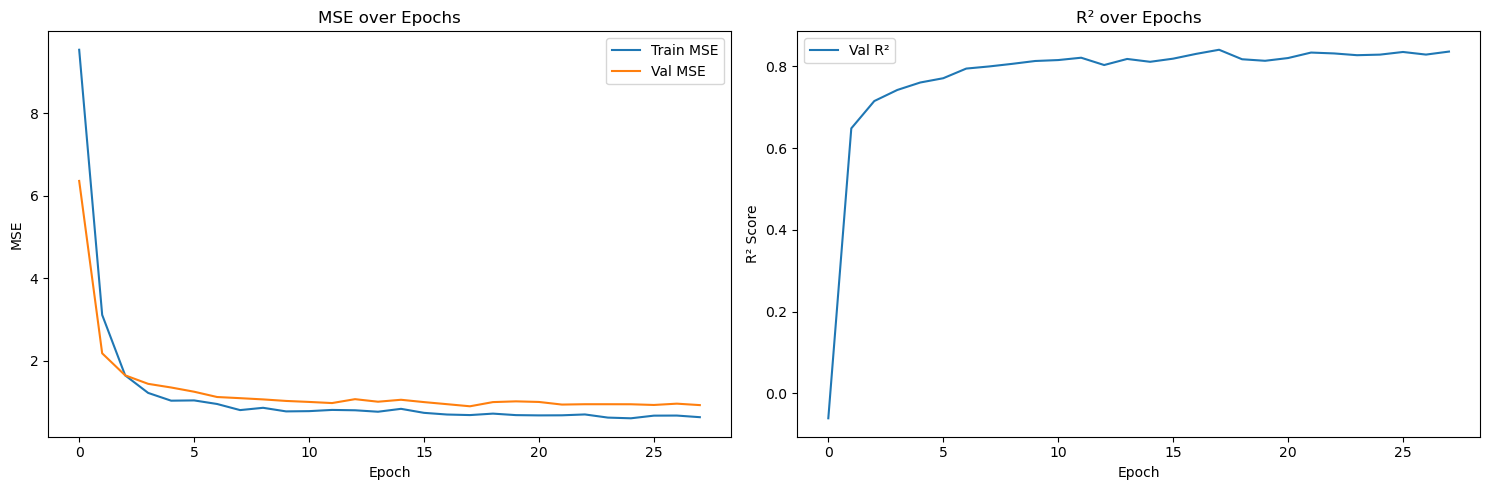

In [ ]:
plt.figure(figsize=(15, 5))

# MSE subplot 
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.title("MSE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# R² subplot 
plt.subplot(1, 2, 2)
plt.plot(val_r2s, label="Val R²")
plt.title("R² over Epochs")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.legend()

plt.tight_layout()
plt.show()


## Step 7: Evaluating the model and plotting results

Test MSE: 0.5971
Test R²: 0.8538


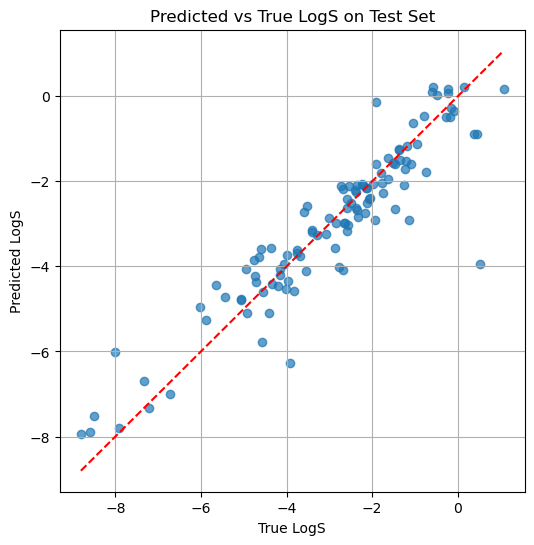

In [ ]:
model.load_state_dict(best_model_wts)

model.eval()
test_losses = []
final_preds = []
final_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        test_losses.append(criterion(out, yb).item())
        final_preds.extend(out.cpu().numpy().flatten())
        final_labels.extend(yb.cpu().numpy().flatten())

mse = np.mean(test_losses)
r2 = r2_score(final_labels, final_preds)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(final_labels, final_preds, alpha=0.7)
plt.plot([min(final_labels), max(final_labels)], [min(final_labels), max(final_labels)], color='red', linestyle='--')
plt.xlabel("True LogS")
plt.ylabel("Predicted LogS")
plt.grid()
plt.title("Predicted vs True LogS on Test Set")
plt.show()